# Setup

In [1]:
!gdown 10iU7sYXgyClvaPLCu23zaWdixgV0KjZy -O malicious_urls.zip
!unzip malicious_urls.zip

Downloading...
From: https://drive.google.com/uc?id=10iU7sYXgyClvaPLCu23zaWdixgV0KjZy
To: /content/malicious_urls.zip
100% 17.7M/17.7M [00:00<00:00, 41.6MB/s]
Archive:  malicious_urls.zip
  inflating: malicious_phish.csv     


In [2]:
!pip -q install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 2.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from urllib.parse import urlparse
import tldextract
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

In [5]:
df = pd.read_csv("./malicious_phish.csv")
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.rename(columns={'type': 'label'}, inplace=True)
df.head()

,url,label
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [6]:
df['label'].value_counts()

benign        428080
defacement     95308
phishing       94092
malware        23645
Name: label, dtype: int64

In [7]:
def extract_url_features(url):
    try:
      extracted = tldextract.extract(url)
      parsed_url = urlparse(url)
    except:
      return {}

    subdomain = extracted.subdomain if extracted.subdomain else ''
    is_www = subdomain.startswith('www')
    domain = extracted.domain
    top_domain = extracted.suffix

    features = {
        'protocol': parsed_url.scheme,
        'is_www': is_www,
        'has_redirect': '->' in url,
        # 'domain': domain or '',
        # 'subdomain': subdomain or '',
        'top_domain': top_domain or '',
        'path_length': len(parsed_url.path),
        'url_length': len(url),
    }

    # Adding character frequencies
    char_features = list("/%=-@.")
    char_frequencies = {f'count{char}': url.count(char) for char in char_features}

    # Merging char_frequencies into features
    features.update(char_frequencies)

    return features

In [8]:
tqdm.pandas(desc="Processing rows")
extracted_features = df['url'].progress_apply(extract_url_features)
extracted_features = pd.DataFrame(extracted_features.tolist())
df.reset_index(drop=True, inplace=True)
extracted_features.reset_index(drop=True, inplace=True)
data_with_features = pd.concat([df, extracted_features], axis=1)

Processing rows: 100%|██████████| 641125/641125 [00:14<00:00, 44867.70it/s]


In [9]:
data_with_features.head()

,url,label,protocol,is_www,has_redirect,top_domain,path_length,url_length,count/,count%,count=,count-,count@,count.
0,br-icloud.com.br,phishing,,False,False,com.br,16,16,0,0,0,1,0,2
1,mp3raid.com/music/krizz_kaliko.html,benign,,False,False,com,35,35,2,0,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,,False,False,org,31,31,3,0,0,0,0,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http,True,False,be,10,88,3,0,4,1,0,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http,False,False,net,10,235,3,0,3,1,0,2


In [10]:
data_with_features['label'].value_counts()

benign        428080
defacement     95308
phishing       94092
malware        23645
Name: label, dtype: int64

# Binay Classification

In [ ]:
data = data_with_features.copy()
categories_to_rename = {'phishing': 'malicious', 'malware': 'malicious', 'defacement': 'malicious'}
data['label'].replace(categories_to_rename, inplace=True)
data = data.drop(['url'], axis=1)
data['label'].value_counts()

benign       428080
malicious    213045
Name: label, dtype: int64

# Multi-Class Classification

In [11]:
data = data_with_features.copy()
data = data.drop(['url'], axis=1)
data_with_features['label'].value_counts()

benign        428080
defacement     95308
phishing       94092
malware        23645
Name: label, dtype: int64

# Model

In [12]:
encoders = {}

encoded_data = data.copy()
for feature in data.select_dtypes(include="object").columns.values:
    encoder = preprocessing.LabelEncoder()
    encoded_data[feature] = encoder.fit_transform(encoded_data[feature])
    encoders[feature] = encoder

encoder_for_label = encoders['label']
encoded_data.head()

,label,protocol,is_www,has_redirect,top_domain,path_length,url_length,count/,count%,count=,count-,count@,count.
0,3,0,False,False,164,16,16,0,0,0,1,0,2
1,0,0,False,False,157,35,35,2,0,0,0,0,2
2,0,0,False,False,662,31,31,3,0,0,0,0,2
3,1,35,True,False,67,10,88,3,0,4,1,0,3
4,1,35,False,False,585,10,235,3,0,3,1,0,2


In [13]:
encoded_data.describe()

,label,protocol,top_domain,path_length,url_length,count/,count%,count=,count-,count@,count.
count,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000
mean,0.662701,9.747187,259.873404,41.075963,59.762232,2.921895,0.398485,0.591637,1.561355,0.002243,2.193950
std,1.085291,15.718614,201.875079,29.820638,44.894451,1.895775,4.166358,1.491300,2.984733,0.054507,1.491443
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,157.000000,21.000000,32.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,157.000000,35.000000,47.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,35.000000,248.000000,53.000000,76.000000,4.000000,0.000000,0.000000,2.000000,0.000000,3.000000
max,3.000000,71.000000,885.000000,2175.000000,2175.000000,41.000000,231.000000,51.000000,87.000000,10.000000,42.000000


In [14]:
x = encoded_data.drop(['label'], axis=1)
y = encoded_data[['label']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare DMatrix
train_reg = xgb.DMatrix(x_train, y_train, enable_categorical=True)
test_reg = xgb.DMatrix(x_test, y_test, enable_categorical=True)

params = {"objective": "multi:softprob", "num_class": len(encoder_for_label.classes_), "eval_metric": "merror"}
model = xgb.train(params=params, dtrain=train_reg, num_boost_round=100)

# Predictions
y_pred = model.predict(test_reg)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
class_report = classification_report(y_test, y_pred_classes)
print(f'\nClassification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85504
           1       0.95      0.98      0.97     19142
           2       0.97      0.87      0.92      4707
           3       0.90      0.81      0.85     18872

    accuracy                           0.96    128225
   macro avg       0.95      0.91      0.93    128225
weighted avg       0.95      0.96      0.95    128225



Confusion matrix, without normalization


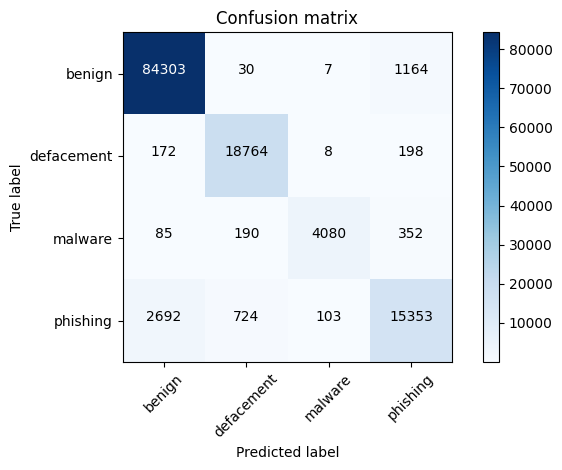

In [16]:
# Confusion Matrix
encoded_label_map = {encoded_label: original_label for encoded_label, original_label in enumerate(encoder_for_label.classes_)}
cm = confusion_matrix(y_test, y_pred_classes, labels = list(encoded_label_map.keys()))
plot_confusion_matrix(cm, classes = list(encoded_label_map.values()))

# Prediction

In [23]:
def preprocess_url(url):
    features = extract_url_features(url)
    features_df = pd.DataFrame([features])

    for feature in features_df.select_dtypes(include="object").columns.values:
        features_df[feature] = encoders[feature].transform(features_df[feature])

    return features_df

def predict_from_url(url):
    processed_data = preprocess_url(url)
    data_dmatrix = xgb.DMatrix(processed_data, enable_categorical=True)

    y_pred = model.predict(data_dmatrix)

    best_class_index = np.argmax(y_pred, axis=1)[0]
    best_class_probability = np.max(y_pred, axis=1)[0]
    best_class_label = encoded_label_map[best_class_index]

    return best_class_label, best_class_probability

# Variant 3

In [41]:
!pip -q install pybloom_live

In [42]:
malicious_urls = df[df['label'] != 'benign']
malicious_classes = list(malicious_urls['label'].unique())
malicious_urls_to_add = malicious_urls.sample(frac=0.5, random_state=42)
value_counts = malicious_urls_to_add['label'].value_counts()

In [43]:
from pybloom_live import BloomFilter

bloom_filters = {class_name: BloomFilter(capacity=value_counts.get(class_name), error_rate=0.001) for class_name in malicious_classes}
normal_bloom_filter = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=0.001)

In [44]:
added_to_bloom_filters = set(malicious_urls_to_add['url'])

for idx, row in tqdm(malicious_urls_to_add.iterrows(), total=len(malicious_urls_to_add)):
    url, label = row['url'], row['label']
    bloom_filters[label].add(url)
    normal_bloom_filter.add(url)

100%|██████████| 106522/106522 [00:08<00:00, 12349.31it/s]


In [45]:
import time

def test_ml_bloom_filters(url, label):
    start_time = time.time()
    predicted_label, _ = predict_from_url(url)
    is_fp, is_fn = False, False
    if predicted_label == 'benign' and label != 'benign':
      is_fn = True
    elif predicted_label != 'benign':
      bloom_filter = bloom_filters[predicted_label]
      bloom_filter_contains_url = bloom_filter.__contains__(url)
      url_added = url in added_to_bloom_filters

      is_fp = bloom_filter_contains_url and not url_added
      is_fn = url_added and not bloom_filter_contains_url

    query_time = time.time() - start_time
    return is_fp, is_fn, query_time

def test_normal_bloom_filter(url):
    start_time = time.time()
    bloom_filter_contains_url = normal_bloom_filter.__contains__(url)
    url_added = url in added_to_bloom_filters
    is_fp = bloom_filter_contains_url and not url_added
    query_time = time.time() - start_time
    return is_fp, query_time

In [46]:
classes = list(df['label'].unique())
test_urls = df.sample(frac=0.1, random_state=42)

# For ML Model + Class-Specific Bloom Filters
fp_ml_class_wise_counts = {class_name: 0 for class_name in classes}
fn_ml_class_wise_counts = {class_name: 0 for class_name in classes}
total_ml_time = 0

# For Normal Bloom Filter - Simulating class-wise FP
fp_bf_class_wise_counts = {class_name: 0 for class_name in classes}
total_bf_time = 0

for idx, row in tqdm(test_urls.iterrows(), total=len(test_urls)):
    url, label = row['url'], row['label']
    # Testing for ML Model + Class-Specific Bloom Filters
    is_fp_ml, is_fn_ml, ml_time = test_ml_bloom_filters(url, label)
    if is_fp_ml:
        fp_ml_class_wise_counts[label] += 1
    if is_fn_ml:
        fn_ml_class_wise_counts[label] += 1
    total_ml_time += ml_time

    # Testing for Normal Bloom Filter
    is_fp_bf, bf_time = test_normal_bloom_filter(url)
    if is_fp_bf:
        fp_bf_class_wise_counts[label] += 1
    total_bf_time += bf_time

100%|██████████| 64112/64112 [11:21<00:00, 94.10it/s] 


In [47]:
value_counts = test_urls['label'].value_counts()
print(value_counts)

benign        42762
defacement     9508
phishing       9501
malware        2341
Name: label, dtype: int64


In [48]:
denominators_fp = {class_name: len(test_urls) - value_counts.get(class_name, 0) for class_name in classes}

# FP Rates for ML model and Bloom Filter - dividing by the respective denominators
fp_rates_ml_class_wise = {class_name: fp_ml_class_wise_counts.get(class_name, 0) / denominators_fp[class_name] for class_name in classes}
fp_rates_bf_class_wise = {class_name: fp_bf_class_wise_counts.get(class_name, 0) / denominators_fp[class_name] for class_name in classes}

# FN Rates for ML model - dividing by total instances of each malicious class
fn_rates_ml_class_wise = {class_name: fn_ml_class_wise_counts.get(class_name, 0) / value_counts.get(class_name, 1) for class_name in classes}

# Average Query Times
avg_ml_time = total_ml_time / len(test_urls)
avg_bf_time = total_bf_time / len(test_urls)

In [49]:
!pip -q install pympler

In [50]:
from pympler import asizeof

ml_model_size = asizeof.asizeof(model)
encoders_size = sum(asizeof.asizeof(encoder) for encoder in encoders.values())
ml_bloom_filters_size = sum(asizeof.asizeof(bloom_filter) for bloom_filter in bloom_filters.values())
total_ml_size = ml_model_size + ml_bloom_filters_size + encoders_size

normal_bf_size = asizeof.asizeof(normal_bloom_filter)


In [51]:
import pandas as pd

results = [{
    "Class": class_name,
    "FP Rate (ML+BF)": fp_rates_ml_class_wise[class_name],
    "FP Rate (Normal BF)": fp_rates_bf_class_wise[class_name],
    "FN Rate (ML+BF)": fn_rates_ml_class_wise[class_name]
} for class_name in classes]

results_df = pd.DataFrame(results)

overall_metrics_df = pd.DataFrame({
    "ML+BF": [avg_ml_time, total_ml_size / 1024],
    "Normal BF": [avg_bf_time, normal_bf_size / 1024]
}, index=["Average Query Time (seconds)", "Memory Footprint (kB)"])

print("Comparison of FP and FN Rates:")
print(results_df.to_string(index=False))

print("\nOverall Performance Metrics:")
print(overall_metrics_df)

Comparison of FP and FN Rates:
     Class  FP Rate (ML+BF)  FP Rate (Normal BF)  FN Rate (ML+BF)
  phishing         0.000037             0.000110         0.162193
    benign         0.000141             0.001733         0.000000
defacement         0.000073             0.000092         0.013988
   malware         0.000000             0.000049         0.079880

Overall Performance Metrics:
                                   ML+BF   Normal BF
Average Query Time (seconds)    0.010003    0.000038
Memory Footprint (kB)         198.945312  187.953125


# Variant 4

In [57]:
def combined_prediction(url):
    if not normal_bloom_filter.__contains__(url):
        best_class_label, best_class_probability = predict_from_url(url)
        return best_class_label
    else:
        return 'malicious'

def test_combined_approach(url, label):
    start_time = time.time()
    predicted_label = combined_prediction(url)

    is_fp, is_fn = False, False
    if predicted_label == 'benign' and label != 'benign':
        is_fn = True
    elif predicted_label != 'benign' and label == 'benign':
        is_fp = True

    query_time = time.time() - start_time
    return is_fp, is_fn, query_time


def test_normal_bloom_filter(url, label):
    start_time = time.time()
    bloom_filter_contains_url = normal_bloom_filter.__contains__(url)
    url_added = url in added_to_bloom_filters
    is_fp = bloom_filter_contains_url and label == 'benign'
    is_fn = label != 'benign' and not bloom_filter_contains_url
    query_time = time.time() - start_time
    return is_fp, is_fn, query_time

In [58]:
fp_combined_counts = fn_combined_counts = total_combined_time = total_bf_time = 0
fp_bf_counts = fn_bf_counts = 0

for idx, row in tqdm(test_urls.iterrows(), total=len(test_urls)):
    url, label = row['url'], row['label']
    is_fp, is_fn, combined_time = test_combined_approach(url, label)
    if is_fp:
        fp_combined_counts += 1
    if is_fn:
        fn_combined_counts += 1
    total_combined_time += combined_time


    is_fp_bf, is_fn_bf, bf_time = test_normal_bloom_filter(url, label)
    if is_fp_bf:
        fp_bf_counts += 1
    if is_fn_bf:
        fn_bf_counts += 1
    total_bf_time += bf_time

100%|██████████| 64112/64112 [09:08<00:00, 116.99it/s]


In [59]:
# Calculating rates and average times
fp_rate_combined = fp_combined_counts / len(test_urls)
fn_rate_combined = fn_combined_counts / len(test_urls)
fp_rate_bf = fp_bf_counts / len(test_urls)
fn_rate_bf = fn_bf_counts / len(test_urls)

avg_combined_time = total_combined_time / len(test_urls)
avg_bf_time = total_bf_time / len(test_urls)

combined_size = normal_bf_size + ml_model_size + encoders_size

results_df = pd.DataFrame({
    "Approach": ["BF+ML", "Normal BF"],
    "FP Rate": [fp_rate_combined, fp_rate_bf],
    "Missed Rate": [fn_rate_combined, fn_rate_bf],
    "Avg Query Time (seconds)": [avg_combined_time, avg_bf_time],
    "Memory (kB)": [combined_size / 1024, normal_bf_size / 1024]
})

print("Performance Comparison:")
print(results_df)

Performance Comparison:
    Approach   FP Rate  Missed Rate  Avg Query Time (seconds)  Memory (kB)
0      BF+ML  0.009858     0.011355                  0.008017   196.906250
1  Normal BF  0.000593     0.165148                  0.000043   187.953125
